# 라이브러리 불러오기

In [1]:
# pip install transformers==3

In [2]:
# pip install mxnet
# pip install gluonnlp pandas tqdm
# pip install sentencepiece
# pip install transformers
# pip install torch

In [3]:
# pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [4]:
# pip install cuda==10.1

In [5]:
import pandas as pd
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import re
from konlpy.tag import Okt
import urllib.request
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# 쇼핑 리뷰 데이터 불러오기

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f0c704cbf70>)

In [7]:
# 열 제목 설정
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [8]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# 긍부정 판단을 위한 라벨 설정

In [9]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [10]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [11]:
# reviews 열에서 중복인 내용이 있다면 중복 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [12]:
print(total_data.isnull().values.any())

False


# OTT 데이터 불러오기

In [13]:
test_data1 = pd.read_csv('./웨이브전처리.csv')
test_data2 = pd.read_csv('./티빙전처리.csv')

In [14]:
del test_data1['Unnamed: 0']
del test_data2['Unnamed: 0']

In [15]:
del test_data1['date']
del test_data1['comment']
del test_data1['nouns']
test_data1.columns = ['ratings', 'reviews', 'label']

del test_data2['date']
del test_data2['comment']
del test_data2['nouns']
test_data2.columns = ['ratings', 'reviews', 'label']

In [16]:
test_data = pd.concat([test_data1,test_data2])

In [17]:
test_data

,ratings,reviews,label
0,1,오류 굉장히 많고 개별구매 영화 개많아요 가뜩이나 비싼데 돈을 얼마나 더받으려고 넷...,0
1,1,한번 더팅기면 회사 소각시켜도되나요,0
2,1,프리미엄 원짜리 후기입니다 일단 사지 마세요 재미있는 영화는 거의다 막아서 프리미엄...,0
3,3,오늘 앱이 죙일 안열리네요 자주 이러면 곤란한데 먼일이데요 언넝 조치를 취해주셔요 ...,0
4,5,ㅡㄴㄴㄱ 즈 ㄱㄴ 그냥 ㄴㄴ ㄴ 드ㅡㅡㅜ ㅣ두 ㄴㄴㅗ트 ㄴ ㅡㅡ ㅡㅡ윤석원드ㅡ ㄴ ...,1
...,...,...,...
15920,5,디자이어 아주 잘됩니다 더좋아지겠죠 볼만한건 유료라지만 유료라도이정도면 볼만한듯,1
15921,1,세상에공짜는 없다 볼만한건전부 유료다 바로삭제,0
15922,1,갤 인데 오류쩔어요,0
15923,5,채널수와 화질에서는 와는 비교가 안되는군요 티빙짱입니다,1


In [18]:
# 인덱스 리셋
test_data.reset_index(drop=True, inplace=True)
test_data

,ratings,reviews,label
0,1,오류 굉장히 많고 개별구매 영화 개많아요 가뜩이나 비싼데 돈을 얼마나 더받으려고 넷...,0
1,1,한번 더팅기면 회사 소각시켜도되나요,0
2,1,프리미엄 원짜리 후기입니다 일단 사지 마세요 재미있는 영화는 거의다 막아서 프리미엄...,0
3,3,오늘 앱이 죙일 안열리네요 자주 이러면 곤란한데 먼일이데요 언넝 조치를 취해주셔요 ...,0
4,5,ㅡㄴㄴㄱ 즈 ㄱㄴ 그냥 ㄴㄴ ㄴ 드ㅡㅡㅜ ㅣ두 ㄴㄴㅗ트 ㄴ ㅡㅡ ㅡㅡ윤석원드ㅡ ㄴ ...,1
...,...,...,...
43312,5,디자이어 아주 잘됩니다 더좋아지겠죠 볼만한건 유료라지만 유료라도이정도면 볼만한듯,1
43313,1,세상에공짜는 없다 볼만한건전부 유료다 바로삭제,0
43314,1,갤 인데 오류쩔어요,0
43315,5,채널수와 화질에서는 와는 비교가 안되는군요 티빙짱입니다,1


# OTT 데이터와 쇼핑 데이터 합치기

In [19]:
# OTT와 쇼핑 리뷰 데이터 concat
total_data = pd.concat([total_data,test_data])
total_data

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
43312,5,디자이어 아주 잘됩니다 더좋아지겠죠 볼만한건 유료라지만 유료라도이정도면 볼만한듯,1
43313,1,세상에공짜는 없다 볼만한건전부 유료다 바로삭제,0
43314,1,갤 인데 오류쩔어요,0
43315,5,채널수와 화질에서는 와는 비교가 안되는군요 티빙짱입니다,1


In [20]:
# 인덱스 리셋
total_data.reset_index(drop=True, inplace=True)
total_data

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
243220,5,디자이어 아주 잘됩니다 더좋아지겠죠 볼만한건 유료라지만 유료라도이정도면 볼만한듯,1
243221,1,세상에공짜는 없다 볼만한건전부 유료다 바로삭제,0
243222,1,갤 인데 오류쩔어요,0
243223,5,채널수와 화질에서는 와는 비교가 안되는군요 티빙짱입니다,1


### total_data 확인 및 null 값 처리

<AxesSubplot:>

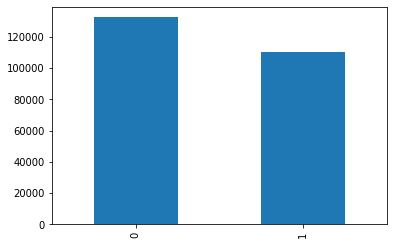

In [21]:
total_data['label'].value_counts().plot(kind = 'bar')

In [22]:
print(total_data.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0  132593
1      1  110632


In [23]:
# Null 값 확인
print(total_data.isnull().values.any())

True


In [24]:
print(total_data.isnull().sum())

ratings      0
reviews    137
label        0
dtype: int64


In [25]:
total_data = total_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(total_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


## train data와 test data로 분리

In [26]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 182316
테스트용 리뷰의 개수 : 60772


### 레이블 분포 확인

<AxesSubplot:>

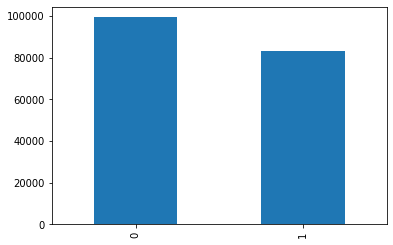

In [27]:
train_data['label'].value_counts().plot(kind = 'bar')

In [28]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  99318
1      1  82998


In [29]:
# Null 값 확인
print(train_data.isnull().values.any())

False


## 전처리 - 훈련셋

In [30]:
# 리뷰 문장 추출
sentences = train_data['reviews']
sentences[:10]

29741     굿 괜찮네요굿배송도빠르게왔네요저렴한지는 잘모르겠지만효과가좋으면괜찮겠네요효과좋겠죠아무...
169589                            재구매 마트보다 고기가 좋아요 믿고 구매합니다
227594               약관동의 창이 아무 내용도 없는 하얀화면인데 어떻게 로그인 하라는건지
923                                     조금더 작은 사이즈 있으면 좋겠어요
105731                                      처음 구매했는데 좋으네요^^
194065                            잘 먹고 있습니다. 꼼꼼한 포장 감사드립니다.
225861    아직 계약이 안된건가여 요즘 드라마 대세가 인데 넘 아쉽습니다 꼭 나오게 좀 해주셔...
59882                            민트색이 예쁘게 나왔어요. 정말 가볍고.예뻐요.
90992                                      버틸컬만 교환할수있어서 좋아요
143786                                          쓰레기에요 하지마세요
Name: reviews, dtype: object

In [31]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 굿 괜찮네요굿배송도빠르게왔네요저렴한지는 잘모르겠지만효과가좋으면괜찮겠네요효과좋겠죠아무튼잘샀어요추천할만햐ㅐ요 [SEP]',
 '[CLS] 재구매 마트보다 고기가 좋아요 믿고 구매합니다 [SEP]',
 '[CLS] 약관동의 창이 아무 내용도 없는 하얀화면인데 어떻게 로그인 하라는건지 [SEP]',
 '[CLS] 조금더 작은 사이즈 있으면 좋겠어요 [SEP]',
 '[CLS] 처음 구매했는데 좋으네요^^ [SEP]',
 '[CLS] 잘 먹고 있습니다. 꼼꼼한 포장 감사드립니다. [SEP]',
 '[CLS] 아직 계약이 안된건가여 요즘 드라마 대세가 인데 넘 아쉽습니다 꼭 나오게 좀 해주셔여 ㅠㅜ [SEP]',
 '[CLS] 민트색이 예쁘게 나왔어요. 정말 가볍고.예뻐요. [SEP]',
 '[CLS] 버틸컬만 교환할수있어서 좋아요 [SEP]',
 '[CLS] 쓰레기에요 하지마세요 [SEP]']

In [32]:
# 라벨 추출
labels = train_data['label'].values
labels

array([1, 1, 0, ..., 0, 1, 1])

In [33]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 굿 괜찮네요굿배송도빠르게왔네요저렴한지는 잘모르겠지만효과가좋으면괜찮겠네요효과좋겠죠아무튼잘샀어요추천할만햐ㅐ요 [SEP]
['[CLS]', '굿', '괜', '##찮', '##네', '##요', '##굿', '##배', '##송', '##도', '##빠', '##르게', '##왔', '##네', '##요', '##저', '##렴', '##한', '##지는', '[UNK]', '[SEP]']


In [34]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   8915,   8904, 119250,  77884,  48549, 118657,  76036,
       119057,  12092, 119008,  78131, 119163,  77884,  48549,  48387,
       118878,  11102,  32815,    100,    102,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [35]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [36]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9303,  16439,  49543,  16439, 119022,  48446, 119112,  10892,
         28911, 119091,  23811,  10739,  37004,    102,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [37]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## 전처리 - 테스트셋


In [38]:
# 리뷰 문장 추출
sentences = test_data['reviews']
sentences[:10]

203568    댓글 지우네 당신들 앱 실행시키고 나니까 폰이 먹통이야 비싼요금제 써가면서 당신들 ...
232565                                     티빙톡은 라이브밖에 없는건가요
156534    평소에 백화점에 자주들러 보테가 지갑을 보는데여 백화점 제품하고 아주 동일합니다 기...
238961                     와이파이뜨는거괜찮은데 보다가갑자기 앱이종료되고 창이종료되요
201059    걍 이번 기회에 사람들 새로 뽑으시죠 일부터 주나 걸린다ㅋㅋㅋ 응대 하시는분들만 고...
142075                    4개구입했는데 유효기한이 길지않아요 1년전에 산거보다 짧아요
223297            이거 너무 불편해요 이거 같이 볼수도 없게하고 명이상은 같이보게 해주셔야줘
192138                            처음 써 봤는데, 적당한 펄감에 지속력 좋네요
47983                               너무 맛있습니당 ㅋ 가성비 짱이네요 ㅎㅎㅎ
66510                                           재밌어요 ㅋㅋㅋ 무지
Name: reviews, dtype: object

In [39]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 댓글 지우네 당신들 앱 실행시키고 나니까 폰이 먹통이야 비싼요금제 써가면서 당신들 앱을 써야돼 타임아웃 같은 문구 띄우지마 안되면 안된다고 얘기하고 공지하라고 영자님아 장난하세요 능력이 안되요 딴생각하지말고 앱안정화나 시키세요 댓글 지우지마 [SEP]',
 '[CLS] 티빙톡은 라이브밖에 없는건가요 [SEP]',
 '[CLS] 평소에 백화점에 자주들러 보테가 지갑을 보는데여 백화점 제품하고 아주 동일합니다 기회가된다면 다음에 꼭 또 구매하고싶네여 [SEP]',
 '[CLS] 와이파이뜨는거괜찮은데 보다가갑자기 앱이종료되고 창이종료되요 [SEP]',
 '[CLS] 걍 이번 기회에 사람들 새로 뽑으시죠 일부터 주나 걸린다ㅋㅋㅋ 응대 하시는분들만 고생이네요 능력없는 프로그래머들 덕분ㅎㅎ [SEP]',
 '[CLS] 4개구입했는데 유효기한이 길지않아요 1년전에 산거보다 짧아요 [SEP]',
 '[CLS] 이거 너무 불편해요 이거 같이 볼수도 없게하고 명이상은 같이보게 해주셔야줘 [SEP]',
 '[CLS] 처음 써 봤는데, 적당한 펄감에 지속력 좋네요 [SEP]',
 '[CLS] 너무 맛있습니당 ㅋ 가성비 짱이네요 ㅎㅎㅎ [SEP]',
 '[CLS] 재밌어요 ㅋㅋㅋ 무지 [SEP]']

In [40]:
# 라벨 추출
labels = test_data['label'].values
labels

array([0, 1, 1, ..., 1, 0, 1])

In [41]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 댓글 지우네 당신들 앱 실행시키고 나니까 폰이 먹통이야 비싼요금제 써가면서 당신들 앱을 써야돼 타임아웃 같은 문구 띄우지마 안되면 안된다고 얘기하고 공지하라고 영자님아 장난하세요 능력이 안되요 딴생각하지말고 앱안정화나 시키세요 댓글 지우지마 [SEP]
['[CLS]', '댓', '##글', '지', '##우', '##네', '당', '##신', '##들', '앱', '실', '##행', '##시', '##키', '##고', '나', '##니', '##까', '폰', '##이', '먹', '##통', '##이', '##야', '비', '##싼', '##요', '##금', '##제', '써', '##가', '##면서', '당', '##신', '##들', '앱', '##을', '써', '##야', '##돼', '타', '##임', '##아', '##웃', '같은', '문', '##구', '띄', '##우', '##지', '##마', '안', '##되', '##면', '안', '##된다', '##고', '얘', '##기', '##하고', '공', '##지', '##하라', '##고', '영', '##자', '##님', '##아', '장', '##난', '##하', '##세', '##요', '능', '##력이', '안', '##되', '##요', '딴', '##생', '##각', '##하지', '##말', '##고', '앱', '##안', '##정', '##화', '##나', '시', '##키', '##세', '##요', '댓', '##글', '지', '##우', '##지', '##마', '[SEP]']


In [42]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9073, 118663,   9706,  27355,  77884,   9067,  25387,
        27023,   9536,   9489,  25549,  14040,  21039,  11664,   8982,
        25503, 118671,   9930,  10739,   9266,  43022,  10739,  21711,
         9379, 119091,  48549,  40032,  17730,   9502,  11287,  30936,
         9067,  25387,  27023,   9536,  10622,   9502,  21711, 118798,
         9845,  36240,  16985, 119170,  18589,   9297,  17196,   9154,
        27355,  12508,  23811,   9521, 118800,  14867,   9521,  22096,
        11664,   9545,  12310,  12453,   8896,  12508, 101656,  11664,
         9574,  13764, 108578,  16985,   9657,  33305,  35506,  24982,
        48549,   9046,  61964,   9521, 118800,  48549,   9132,  24017,
        66540,  23665,  89523,  11664,   9536,  34951,  16605,  18227,
        16439,   9485,  21039,  24982,  48549,   9073, 118663,   9706,
        27355,  12508,  23811,    102,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [43]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [44]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   9073, 118663,   9706,  27355,  77884,   9067,  25387,  27023,
          9536,   9489,  25549,  14040,  21039,  11664,   8982,  25503, 118671,
          9930,  10739,   9266,  43022,  10739,  21711,   9379, 119091,  48549,
         40032,  17730,   9502,  11287,  30936,   9067,  25387,  27023,   9536,
         10622,   9502,  21711, 118798,   9845,  36240,  16985, 119170,  18589,
          9297,  17196,   9154,  27355,  12508,  23811,   9521, 118800,  14867,
          9521,  22096,  11664,   9545,  12310,  12453,   8896,  12508, 101656,
         11664,   9574,  13764, 108578,  16985,   9657,  33305,  35506,  24982,
         48549,   9046,  61964,   9521, 118800,  48549,   9132,  24017,  66540,
         23665,  89523,  11664,   9536,  34951,  16605,  18227,  16439,   9485,
         21039,  24982,  48549,   9073, 118663,   9706,  27355,  12508,  23811,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [45]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 모델 생성

In [46]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [47]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1080 Ti


In [48]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [49]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 모델 학습

In [50]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [51]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [52]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  5,128.    Elapsed: 0:02:47.
  Batch 1,000  of  5,128.    Elapsed: 0:05:35.
  Batch 1,500  of  5,128.    Elapsed: 0:08:23.
  Batch 2,000  of  5,128.    Elapsed: 0:11:11.
  Batch 2,500  of  5,128.    Elapsed: 0:13:59.
  Batch 3,000  of  5,128.    Elapsed: 0:16:47.
  Batch 3,500  of  5,128.    Elapsed: 0:19:35.
  Batch 4,000  of  5,128.    Elapsed: 0:22:24.
  Batch 4,500  of  5,128.    Elapsed: 0:25:12.
  Batch 5,000  of  5,128.    Elapsed: 0:28:01.

  Average training loss: 0.27
  Training epcoh took: 0:28:44

Running Validation...
  Accuracy: 0.91
  Validation took: 0:01:01

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  5,128.    Elapsed: 0:03:03.
  Batch 1,000  of  5,128.    Elapsed: 0:06:20.
  Batch 1,500  of  5,128.    Elapsed: 0:09:13.
  Batch 2,000  of  5,128.    Elapsed: 0:12:01.
  Batch 2,500  of  5,128.    Elapsed: 0:14:49.
  Batch 3,000  of  5,128.    Elapsed: 0:17:37.
  Batch 3,500  of  5,128.    Elap

# 테스트셋 평가

In [53]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of  1,900.    Elapsed: 0:00:11.
  Batch   200  of  1,900.    Elapsed: 0:00:21.
  Batch   300  of  1,900.    Elapsed: 0:00:32.
  Batch   400  of  1,900.    Elapsed: 0:00:43.
  Batch   500  of  1,900.    Elapsed: 0:00:53.
  Batch   600  of  1,900.    Elapsed: 0:01:04.
  Batch   700  of  1,900.    Elapsed: 0:01:14.
  Batch   800  of  1,900.    Elapsed: 0:01:25.
  Batch   900  of  1,900.    Elapsed: 0:01:36.
  Batch 1,000  of  1,900.    Elapsed: 0:01:46.
  Batch 1,100  of  1,900.    Elapsed: 0:01:57.
  Batch 1,200  of  1,900.    Elapsed: 0:02:08.
  Batch 1,300  of  1,900.    Elapsed: 0:02:18.
  Batch 1,400  of  1,900.    Elapsed: 0:02:29.
  Batch 1,500  of  1,900.    Elapsed: 0:02:39.
  Batch 1,600  of  1,900.    Elapsed: 0:02:50.
  Batch 1,700  of  1,900.    Elapsed: 0:03:01.
  Batch 1,800  of  1,900.    Elapsed: 0:03:11.

Accuracy: 0.92
Test took: 0:03:22


# 새로운 문장 테스트

In [54]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [55]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [56]:
logits = test_sentences(['한번 더팅기면 회사 소각시켜도되나요'])

print(logits)
print(np.argmax(logits))

if(np.argmax(logits) == 1):
    print("긍정 리뷰입니다.")
else:
    print("부정 리뷰입니다.")

[[ 1.0768989 -0.7515797]]
0
부정 리뷰입니다.


In [57]:
logits = test_sentences(['이거 시간 돌리기 쓰면 화질깨지고 최악이에요'])

print(logits)
print(np.argmax(logits))

if(np.argmax(logits) == 1):
    print("긍정 리뷰입니다.")
else:
    print("부정 리뷰입니다.")

[[ 3.3840263 -3.059722 ]]
0
부정 리뷰입니다.


In [58]:
logits = test_sentences(['넘넘 좋아요 유용합니다'])

print(logits)
print(np.argmax(logits))

if(np.argmax(logits) == 1):
    print("긍정 리뷰입니다.")
else:
    print("부정 리뷰입니다.")

[[-2.1918442  1.2627723]]
1
긍정 리뷰입니다.


In [59]:
logits = test_sentences(['최고의 어플이네요 정말정말 좋습니다'])

print(logits)
print(np.argmax(logits))

if(np.argmax(logits) == 1):
    print("긍정 리뷰입니다.")
else:
    print("부정 리뷰입니다.")

[[-2.8046587  2.037396 ]]
1
긍정 리뷰입니다.
